In [1]:
import warnings
warnings.filterwarnings('ignore')
import logging
import numpy as np
import pandas as pd
from datetime import date,datetime,timedelta
from pytz import timezone

import matplotlib.pyplot as plt

import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import r2_score

In [2]:
# read in data and rename column
df=pd.read_csv('IND3_EventData.csv')
df.rename(columns={'CNT':'PKG_COUNT','TRACKINGEVENTKEY':'EVENT_KEY','EVENT_DAY':'EVENT_DATE'},inplace=True)

df.head()

,EVENT_DATE,EVENT_KEY,PKG_COUNT
0,2021-05-20 00:00:00.000,334,2462
1,2021-05-20 00:00:00.000,333,2916
2,2021-05-20 00:00:00.000,35,1883
3,2021-05-20 00:00:00.000,7,1156
4,2021-05-20 00:00:00.000,14,7677


In [3]:
# find min and max datetime in data and change to datetime format
print(min(df['EVENT_DATE']),'-',max(df['EVENT_DATE']))
df['EVENT_DATE']=pd.to_datetime(df['EVENT_DATE'])

df.head()

2020-06-01 01:00:00.000 - 2021-05-20 00:00:00.000


,EVENT_DATE,EVENT_KEY,PKG_COUNT
0,2021-05-20,334,2462
1,2021-05-20,333,2916
2,2021-05-20,35,1883
3,2021-05-20,7,1156
4,2021-05-20,14,7677


In [4]:
total_day=(max(df['EVENT_DATE']) - min(df['EVENT_DATE'])).days
print(total_day)

352


In [5]:
# import prophet
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [6]:
# empty dataframe to append forecast results
Final=pd.DataFrame()

In [7]:
# find unique events
Event_List=list(df['EVENT_KEY'].unique())
print(Event_List)

[334, 333, 35, 7, 14, 335, 33, 339, 337, 336, 325, 75, 76]


In [8]:
# length of training period (days) - 70% of total days
training_period=round(0.7*total_day,0) 

# training interval increment (days)
interval=7

# window between checkpoint (hours)
window='6H'

#number of forecast (based on windows between checkpoint)
number_of_forecast = 24/int(window[0])

for evnt in Event_List:
    print('Event ',evnt)

    # sort tracking event by key
    pre_train=df[df['EVENT_KEY']==evnt]

    #drop Event_Key column
    pre_train.drop(['EVENT_KEY'],axis=1,inplace=True) 

    # the n+1 day - the day after as a start date for forecasting
    min_val=(min(pre_train['EVENT_DATE'])+timedelta(days=1)).round('D')
    max_val=max(pre_train['EVENT_DATE'])

    temp=pd.DataFrame()

    # sort datetime by Event_Key
    # 6-hour increment
    temp['EVENT_DATE']=pd.Series(pd.date_range(min_val,max_val,freq=window))

    pre_train=pre_train.merge(temp,how='right',left_on='EVENT_DATE',right_on='EVENT_DATE')
    pre_train['EVENT_DATE']=pre_train['EVENT_DATE'].fillna(0)

    # training period
    len_train=pd.to_datetime(min_val)+timedelta(days=training_period) 
    flag=len_train

#     pre_train.dropna(inplace=True)
    pre_train=pre_train.sort_values(['EVENT_DATE'])

    while (flag+timedelta(days=interval))<=pd.to_datetime(max_val):
        forecast=pd.DataFrame()

        # training set with datetime smaller than flag
        # rename column and convert to datetime format
        train=pre_train[pre_train['EVENT_DATE']<flag]
        train.columns = ['ds', 'y']
        train['ds']= pd.to_datetime(train['ds'])

        # define the model
        model = Prophet()
#         daily_seasonality=True
#         yearly_seasonality=False

        # fit the model
        model.fit(train)

        # future dataframe with the beginning of training period as a start date
        # 6-hourly period in 7 days
        future=pd.DataFrame(pd.Series(pd.date_range(start=flag, periods=number_of_forecast*interval,freq=window)),columns=['ds'])

        forecast = model.predict(future)
        forecast['Event']=evnt

        #append forecast result
        Final=Final.append(forecast)
        flag=flag+timedelta(days=interval)

Event  334


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Event  333


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Event  35


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=Tru

Event  7


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=Tru

Event  14


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=Tru

Event  335


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=Tru

Event  33


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=Tru

Event  339
Event  337


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=Tru

Event  336


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 17.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 17.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 17.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 17.


Event  325
Event  75
Event  76


In [9]:
# final y-hat=0 if smaller than 0
Final['yhat']=np.where(Final['yhat']<0,0,Final['yhat'])

df_t=df
df_t['EVENT_DATE']=pd.to_datetime(df_t['EVENT_DATE'])

Final_CSV=Final.merge(df_t,how='left',left_on=['ds','Event'],right_on=['EVENT_DATE','EVENT_KEY'])
Final_CSV['PKG_COUNT']=Final_CSV['PKG_COUNT'].fillna(0)
Final_CSV.to_csv('IND3_Anomaly_Output_7Day.csv')

In [10]:
final_event_list=list(Final_CSV['Event'].unique())
print(final_event_list)

total_final_day=(max(Final_CSV['ds']) - min(Final_CSV['ds'])).days
print(total_final_day)

[334, 333, 35, 7, 14, 335, 33, 337, 336]
104


In [11]:
# cleaning before visualization

# no negative volume: 0 for yhat_lower < 0
Final_CSV['yhat_lower']=np.where(Final_CSV['yhat_lower']<0,0,Final_CSV['yhat_lower'])

# round to nearest int
Final_CSV.yhat_upper=Final_CSV.yhat_upper.round(decimals=0)
Final_CSV.yhat_lower=Final_CSV.yhat_lower.round(decimals=0)
Final_CSV.yhat=Final_CSV.yhat.round(decimals=0)

# Final_CSV.head()
Final_CSV.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,Event,EVENT_DATE,EVENT_KEY,PKG_COUNT
2879,2021-05-15 18:00:00,-1923.500998,0.0,12309.0,-1923.501047,-1923.500950,8254.263310,8254.263310,8254.263310,7021.423060,...,1232.840250,1232.840250,0.0,0.0,0.0,6331.0,336,NaT,NaN,0.0
2880,2021-05-16 00:00:00,-1926.876947,9037.0,20990.0,-1926.876997,-1926.876898,16863.541798,16863.541798,16863.541798,8581.732127,...,8281.809670,8281.809670,0.0,0.0,0.0,14937.0,336,NaT,NaN,0.0
2881,2021-05-16 06:00:00,-1930.252896,8171.0,21305.0,-1930.252946,-1930.252847,16322.731158,16322.731158,16322.731158,2332.001471,...,13990.729686,13990.729686,0.0,0.0,0.0,14392.0,336,NaT,NaN,0.0
2882,2021-05-16 12:00:00,-1933.628845,19171.0,31756.0,-1933.628895,-1933.628795,27338.754797,27338.754797,27338.754797,10908.909216,...,16429.845581,16429.845581,0.0,0.0,0.0,25405.0,336,NaT,NaN,0.0
2883,2021-05-16 18:00:00,-1937.004794,13584.0,26268.0,-1937.004845,-1937.004744,21798.840696,21798.840696,21798.840696,7021.423061,...,14777.417636,14777.417636,0.0,0.0,0.0,19862.0,336,NaT,NaN,0.0


Event  334


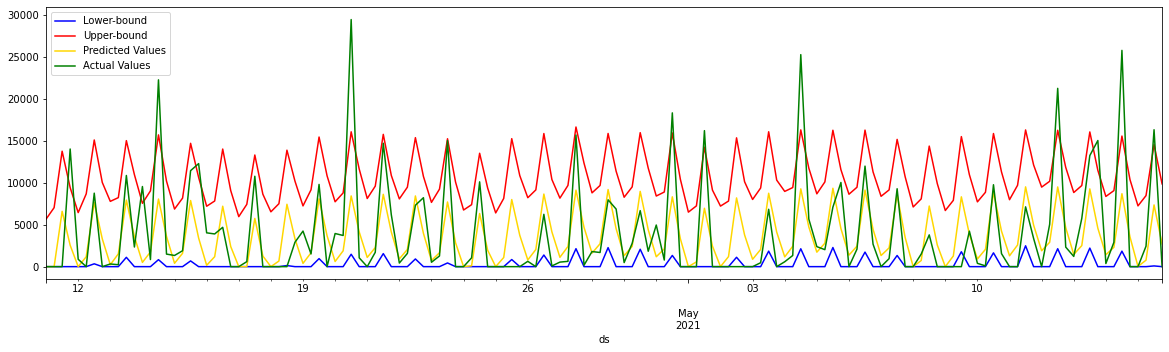

Event  333


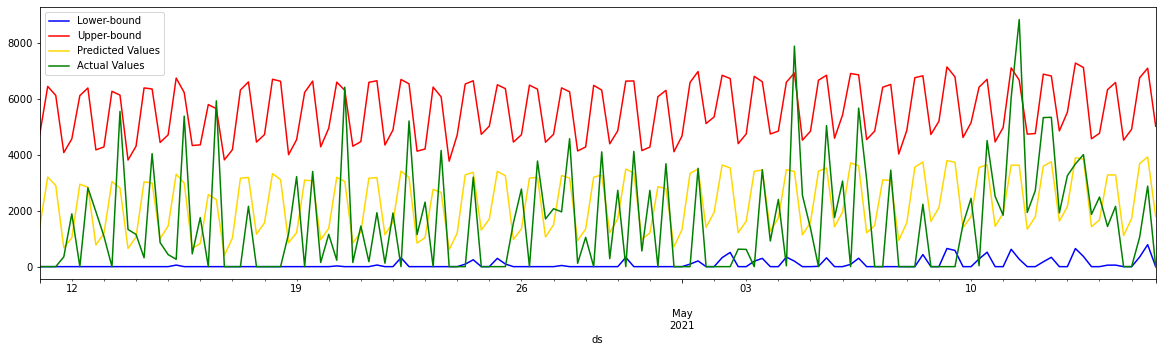

Event  35


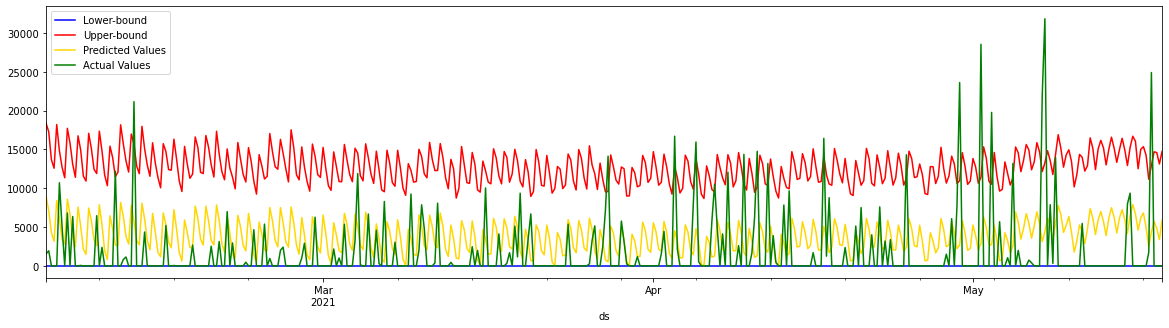

Event  7


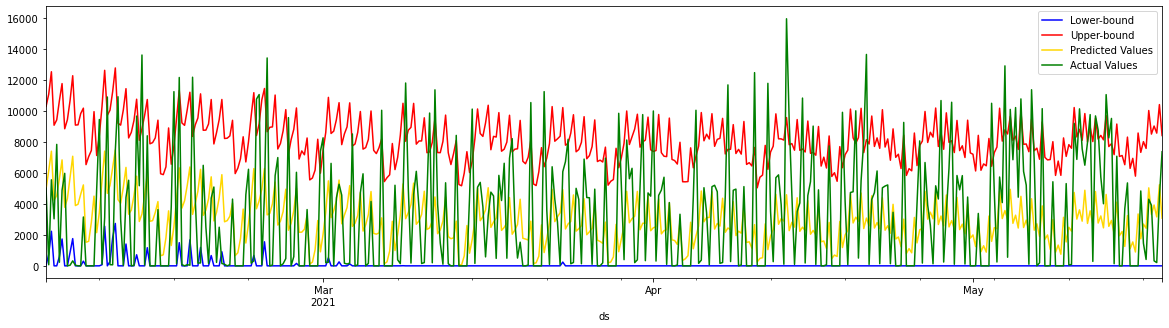

Event  14


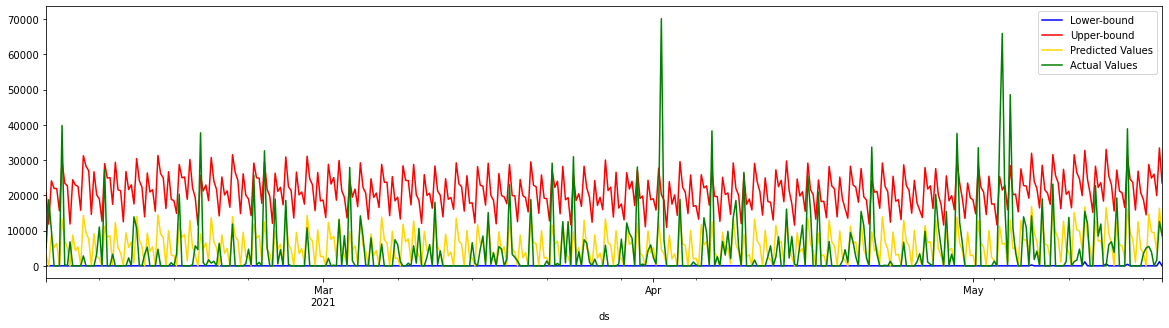

Event  335


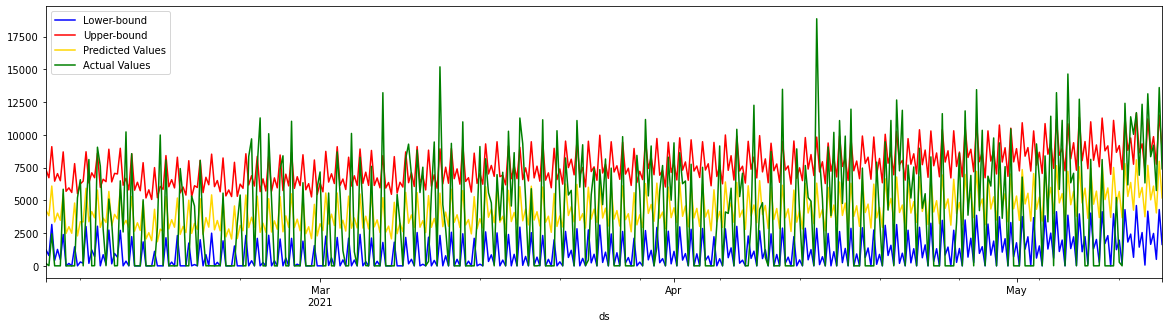

Event  33


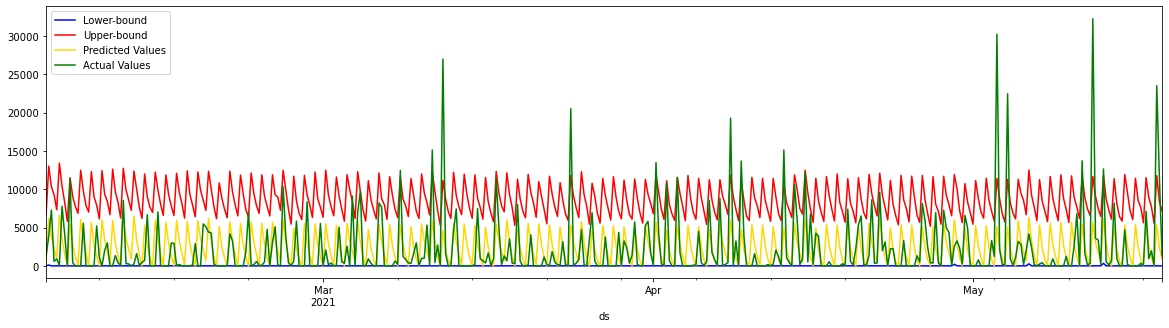

Event  337


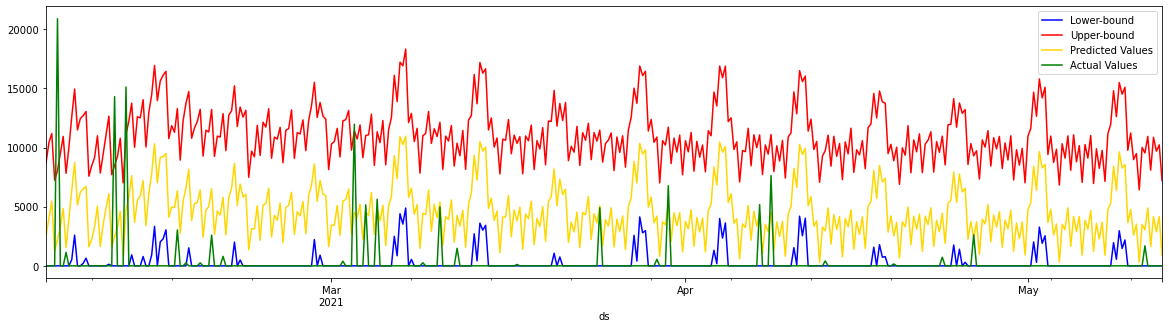

Event  336


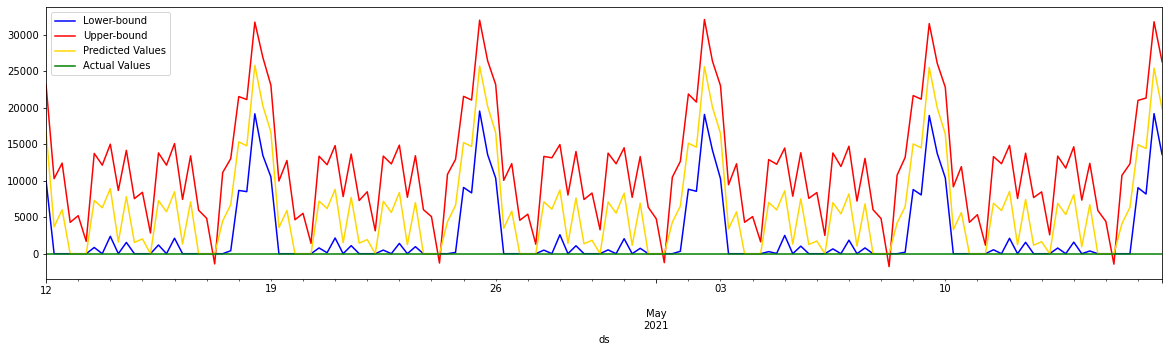

In [12]:
#all time - graph plot with date, confidence interval, predicted and actual values

for final_evnt in final_event_list:
    print('Event ',final_evnt) 

    spec_event=Final_CSV[Final_CSV['Event'] == final_evnt]

    ax = plt.gca()

    spec_event.plot(kind='line',x='ds',y='yhat_lower', color='blue', label='Lower-bound', ax=ax, figsize=(20, 5))
    spec_event.plot(kind='line',x='ds',y='yhat_upper', color='red', label='Upper-bound', ax=ax, figsize=(20, 5))

    spec_event.plot(kind='line',x='ds',y='yhat', color='gold', label='Predicted Values', ax=ax, figsize=(20, 5))
    spec_event.plot(kind='line',x='ds',y='PKG_COUNT', color='green', label='Actual Values', ax=ax, figsize=(20, 5))

    plt.fill_between(spec_event.index, spec_event.yhat_upper, spec_event.yhat_lower, facecolor='orange',alpha=0.5)

    plt.show()

Event  334


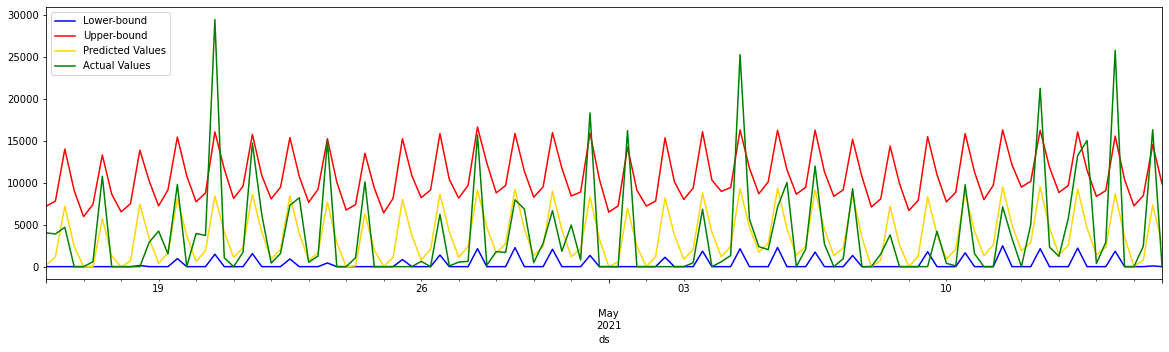

Event  333


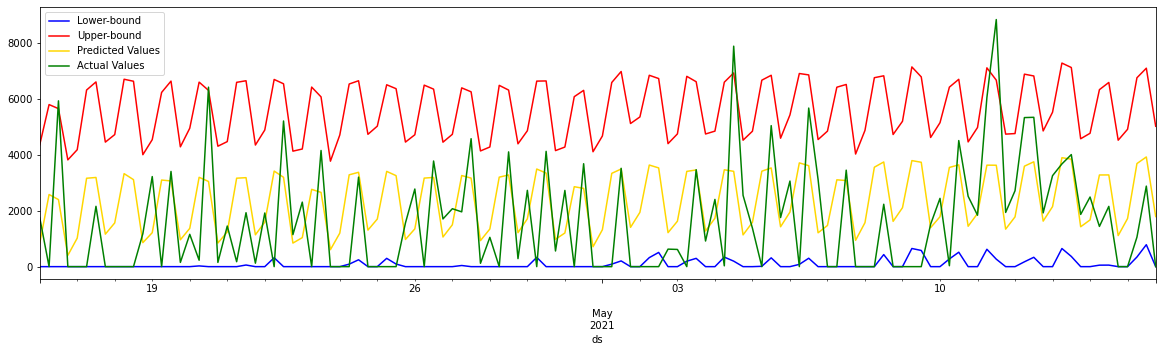

Event  35


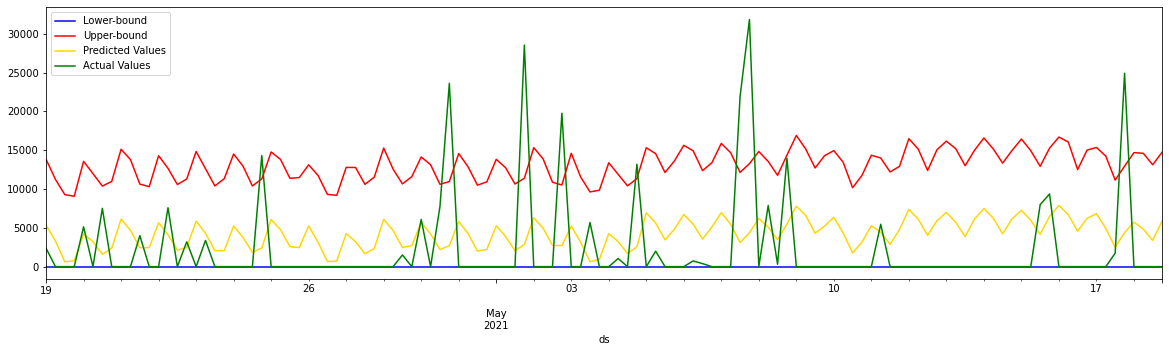

Event  7


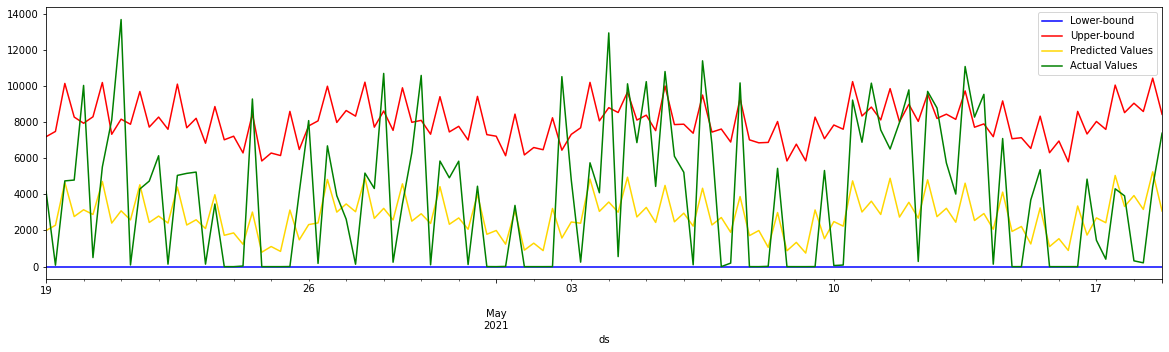

Event  14


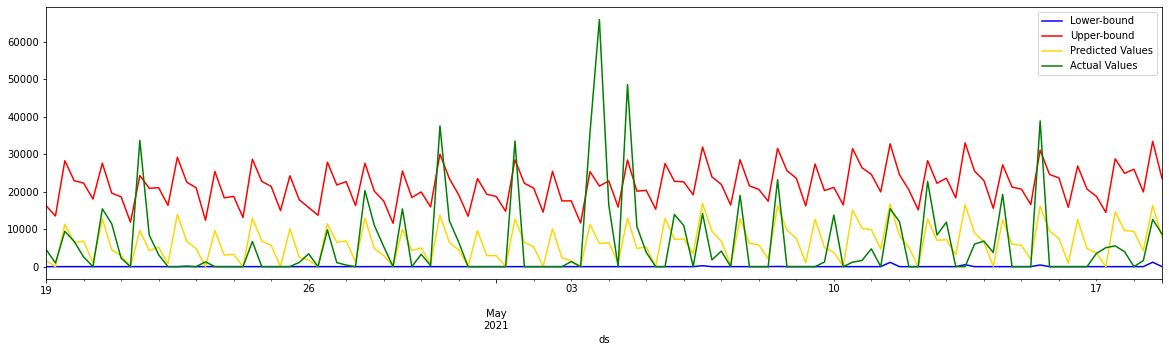

Event  335


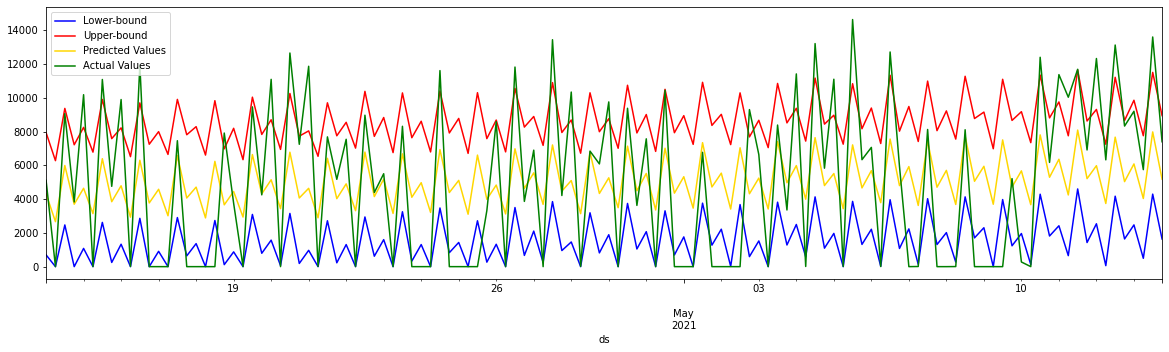

Event  33


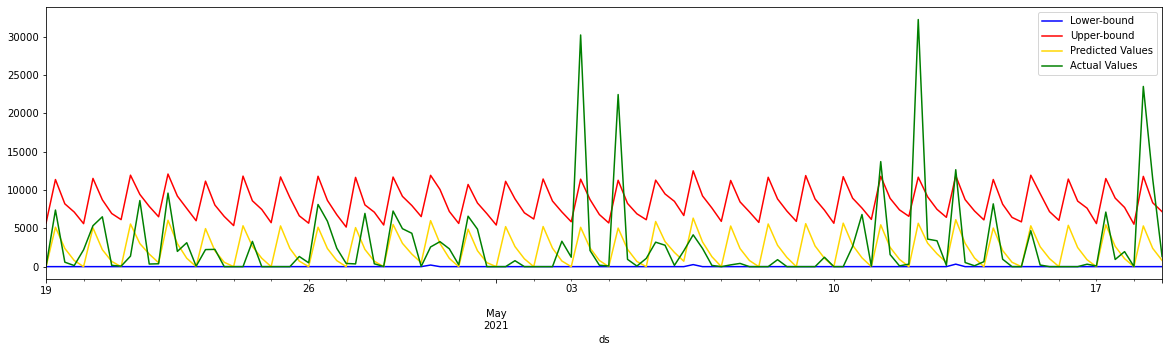

Event  337


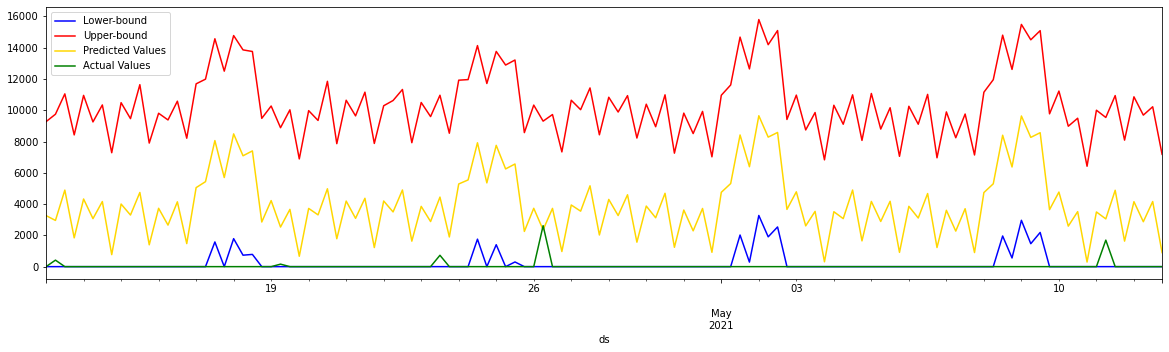

Event  336


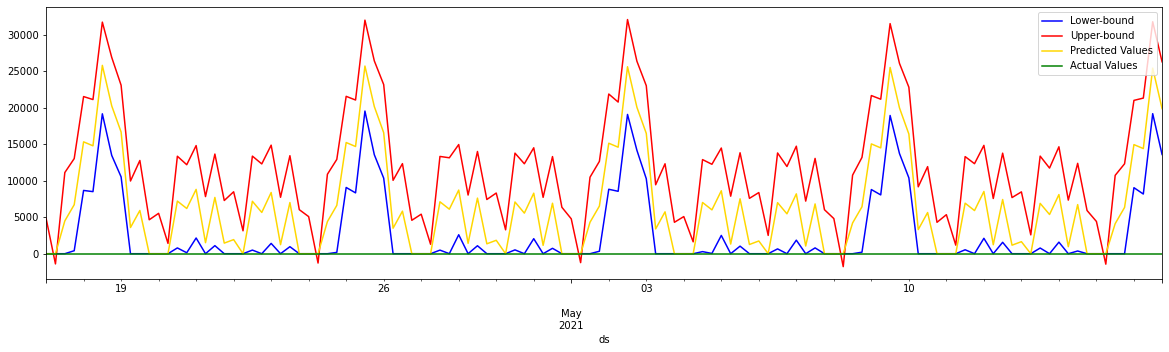

In [13]:
#most recent 30 days - graph plot with date, confidence interval, predicted and actual values

for final_evnt in final_event_list:
    print('Event ',final_evnt) 

    spec_event=Final_CSV[Final_CSV['Event'] == final_evnt]
    
    recent_30d = spec_event[(spec_event['ds'] > spec_event['ds'].iloc[-1]-timedelta(days=30))
                         & (spec_event['ds'] <= spec_event['ds'].iloc[-1])]
    
    ax = plt.gca()

    recent_30d.plot(kind='line',x='ds',y='yhat_lower', color='blue', label='Lower-bound', ax=ax, figsize=(20, 5))
    recent_30d.plot(kind='line',x='ds',y='yhat_upper', color='red', label='Upper-bound', ax=ax, figsize=(20, 5))

    recent_30d.plot(kind='line',x='ds',y='yhat', color='gold', label='Predicted Values', ax=ax, figsize=(20, 5))
    recent_30d.plot(kind='line',x='ds',y='PKG_COUNT', color='green', label='Actual Values', ax=ax, figsize=(20, 5))

    plt.fill_between(recent_30d.index, recent_30d.yhat_upper, recent_30d.yhat_lower, facecolor='orange',alpha=0.5)

    plt.show()

In [14]:
# all time metrics
y_pred=Final_CSV['yhat']
y_actual=Final_CSV['PKG_COUNT']
sample=len(Final_CSV.index)

mse = mean_squared_error(y_actual,y_pred)
rmse = math.sqrt(mse/sample)
rse = math.sqrt(mse/(sample-2))
r2=r2_score(y_actual,y_pred)
mae=mean_absolute_error(y_actual,y_pred)
median_ae=median_absolute_error(y_actual, y_pred)
mask=y_actual!=0
mape=(np.fabs((y_actual-y_pred)/y_actual))[mask].mean()
mpe=((y_actual-y_pred)/y_actual)[mask].mean()
med_ape=(np.fabs((y_actual-y_pred)/y_actual))[mask].median()
forecast_error = [y_actual[i]-y_pred[i] for i in range(len(y_pred))]
mean_forecast_error=sum(forecast_error)/len(y_pred)
smape=1/len(y_actual) * np.sum(2 * np.abs(y_pred-y_actual) / (np.abs(y_actual) + np.abs(y_pred))*100)
wape=np.sum(np.abs(y_actual-y_pred))/np.sum(np.abs(y_actual))
msle=mean_squared_log_error(y_actual, y_pred)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('RSE: ', rse)
print('R^2: ', r2)
print('MAE: ', mae)
print('Median_AE: ', median_ae)
print('MPE: ', mpe)
print('MAPE:', mape)
print('MdAPE:', med_ape)
print('Mean Forecast Error: ', mean_forecast_error)
print('SMAPE: ', smape)
print('WAPE: ', wape)
print('MSLE: ', msle)
print('RMSLE: ', np.sqrt(msle))

MSE:  29278890.431692094
RMSE:  100.75803267381828
RSE:  100.7929877599258
R^2:  -0.08707298492659699
MAE:  3736.9205963938975
Median_AE:  2923.5
MPE:  -111.62339794984594
MAPE: 112.17857558888804
MdAPE: 0.6283772955460976
Mean Forecast Error:  -1306.5856449375867
SMAPE:  137.32310729125632
WAPE:  1.421405198802975
MSLE:  32.64115439248061
RMSLE:  5.713243771490991


In [15]:
#Interpretation
print("We are having an overestimated model, with MAPE > 100% and negative Mean Forecast/Percentage Error.") #MAPE/MFE/MPE
print("We should expect an average error of +- 101 packages, with RMSE are around 100.") #RMSE
print("The forecast error is 1.4%, meaning accuracy is 98.6%") #WAPE

### Unusable metrics interpretation ###
# print("The forecast's distance from the true value is 112% above of the true value, \ 
# which is around 3737 packages.") #MAPE/MAE
# print("Actual results are 112% less than what was forecasted. ") #MPE
# print("Half of the packages count are falling between median +- 2923 counts.") #Median_AE
# print("Half of the absolute percentage errors are less than 0.63% and half are over 0.63%.") #MdAPE

We are having an overestimated model, with MAPE > 100% and negative Mean Forecast/Percentage Error.
We should expect an average error of +- 101 packages, with RMSE are around 100.
The forecast error is 1.4%, meaning accuracy is 98.6%


In [16]:
# Format output file
facility_name = 'IND3'
forecast_purpose = 'Event Count'

#Forecast Date/Time
Final_CSV['ds']=pd.to_datetime(Final_CSV['ds']) 
Final_CSV['Forecast Date']=[(d.date()).strftime("%d %b %Y") for d in Final_CSV['ds']]
Final_CSV['Forecast Time']=[(d.time()).strftime("%I:%M %p") for d in Final_CSV['ds']]

#Lower/Upper boundary, Actuals, Forecast renames
Final_CSV.rename(columns={'yhat_lower':'Lower Boundary','yhat_upper':'Upper Boundary','PKG_COUNT':'Actual','yhat':'Forecast'},inplace=True)

#Model Performance/Sensitivity
Final_CSV['Model Performance']=round(100-np.sum(np.abs(y_actual-y_pred))/np.sum(np.abs(y_actual)),2).astype(str)+"%"

#Anomaly
conditions = [
    Final_CSV['Actual'] < Final_CSV['Forecast'],
    Final_CSV['Actual'] > Final_CSV['Forecast'],
    Final_CSV['Actual'] == Final_CSV['Forecast']
]

choices = ["Lower than expected", "Higher than expected", "Same as expected"]
Final_CSV['Anomaly'] = np.select(conditions, choices)

#Run date/time
Final_CSV['Run Date']= (datetime.now().date()).strftime("%d %b %Y")
Final_CSV['Run Time']= (datetime.now().time()).strftime("%I:%M %p")

#Sensitivity, version, comment - empty for now
Final_CSV["Sensitivity"],Final_CSV["Version"],Final_CSV["Comment"] = "","",""

#Monitor Name
Final_CSV["Monitor Name"] = facility_name +" "+ forecast_purpose

#Rearranging columns
cols = Final_CSV.columns.tolist()
cols = ['Monitor Name',
        'Version',
        'Event',
        'Run Date',
        'Run Time',
        'Forecast Date',
        'Forecast Time',
        'Model Performance',
        'Sensitivity',
        'Lower Boundary',
        'Upper Boundary',
        'Forecast',
        'Actual',
        'Anomaly',
        'Comment'
       ]
Final_CSV=Final_CSV[cols]
Final_CSV.tail()
Final_CSV.to_csv('IND3_Anomaly_Output_7Day_Formatted.csv')